In [1]:
import numpy as np
import os
import sys
import copy
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict
import time
import loadcifar
from loadcifar import *
list_pathstoadd = [
    "../../"
]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
#import generalGPmodule
import localsrc_cifar10demo
from localsrc_cifar10demo import *
import gpex
import resnetforcifar
from resnetforcifar import *
from gpex.kernelmappings.image import Resnet50BackboneKernelDivideAvgPool

In [2]:
#settings ====
idx_trainingbatch = 1
flag_enabledataaugmentation = True
fname_gpmodel = os.path.join(
    "..",
    "..",
    "Material_PaperResults",
    "Models",
    "ExplainAttention",
    "cifar10.pt"
)

#"../../Material_PaperResults/Models/ExplainAttention/cifar10.pt"
#"TrainingHistory/Phase2/Nov17_Explainattention_onBeluga/"+\
#                "output_explainattention_version4_afterepoch2.pt"
int_mode_modulekernel = 16
flag_train_memefficient, memefficeint_heads_in_compgraph = False, None
du_per_class = 20
int_exposedclass = None
idx_split = 0
dim_wideoutput = 1024
dim_before_wideoutput_attention = 200
num_classes = 10
batchsize = 10
flag_efficient = True
flag_detachcovpvn = True
flag_controlvariate = True
flag_setcovtoOne = False
int_mode_controlvariate = 2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
#make datasets ====
ds_rootdir = os.path.join(
    "..",
    "..",
    "Material_PaperResults",
    "Datasets",
    "Cifar10"
)
ds_train = Cifar10Dataset(
    rootdir = ds_rootdir,
    fname_batchfile = "data_batch_{}".format(idx_trainingbatch),
    str_trainoreval = "train",
    flag_enabledataaugmentation = flag_enabledataaugmentation
)
ds_inducing = Cifar10Dataset(
    rootdir = ds_rootdir,
    fname_batchfile = "data_batch_{}".format(idx_trainingbatch),
    str_trainoreval = "eval"
)
ds_test = Cifar10Dataset(
    rootdir = ds_rootdir,
    fname_batchfile = "test_batch",
    str_trainoreval = "eval"
)

In [5]:
dl_train = DataLoader(ds_train, batch_size=batchsize,
                      shuffle=True, num_workers=0)
dl_inducing = DataLoader(ds_inducing, batch_size=batchsize,
                          shuffle=True, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=batchsize,
                     shuffle=False, num_workers=0)

In [6]:
model = MainModuleAttention(
    dim_wideoutput=dim_wideoutput,
    num_classes = num_classes,
    device = device,
    ds_inducing = ds_inducing,
    dl_recurring = dl_inducing,
    dl_nonrecurring = dl_train,
    dl_test = dl_test,
    batchsize = batchsize
  )
model.to(device)
print("model was created on {}.".format(device))

self.size_output was set to [512, 4, 4].
self.size_output was set to [1, 4, 4].
C_head is equal to 2048.
model was created on cuda:0.


In [7]:
gpexmodule = gpex.GPEXModule(
    module_rawmodule = model,
    size_recurringdataset = len(ds_inducing),
    device = device,
    func_mainmodule_to_moduletobecomeGP = model.func_mainmodule_to_moduletobecomeGP, 
    func_feed_noise_minibatch = model.func_feed_noise_minibatch,
    func_feed_inducing_minibatch = model.func_feed_recurring_minibatch,
    func_feed_nonrecurring_minibatch = model.func_feed_nonrecurring_minibatch,
    func_feed_test_minibatch = model.func_feed_test_minibatch,
    func_get_indices_lastrecurringinstances = model.func_get_indices_lastrecurringinstances,
    func_get_modulef1 = model.func_get_modulef1,
    flag_efficient = flag_efficient,
    flag_detachcovpvn = flag_detachcovpvn,
    flag_controlvariate = flag_controlvariate,
    flag_setcovtoOne = flag_setcovtoOne,
    int_mode_controlvariate = int_mode_controlvariate,
    flag_train_memefficient = flag_train_memefficient,
    memefficeint_heads_in_compgraph = memefficeint_heads_in_compgraph
)
#model.n_subsampleminibatch = 50
gpexmodule.sigma2_GP = 1.0 #TODO:check
gpexmodule.train()
gpexmodule.to(device)
print("gpmodel was created on {}".format(device))

Controlvariate mode is set to 2
x.shape = torch.Size([10, 3, 32, 32])
    Dv was set to 16
gpmodel was created on cuda:0


/home/user1/anaconda3/envs/envpy37/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
gpexmodule.load_state_dict(
    torch.load(
        fname_gpmodel
     ),
    strict = True
)
gpexmodule.train()
gpexmodule.to(device)
gpexmodule.renew_precomputed_XTX()
print("gpexmodule was loaded from checkpoint.")

gpexmodule was loaded from checkpoint.


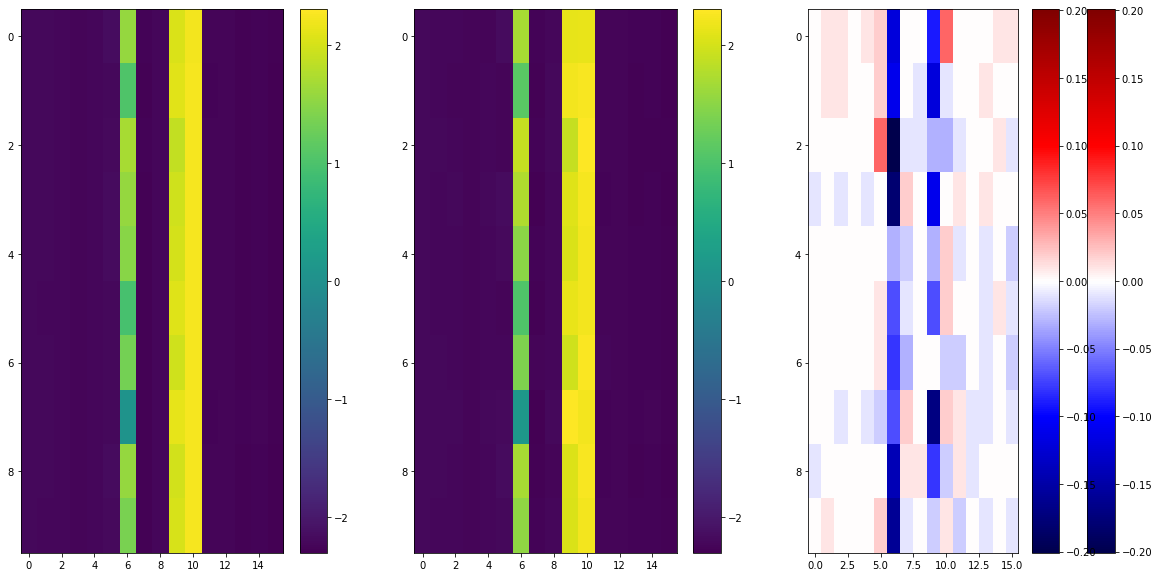

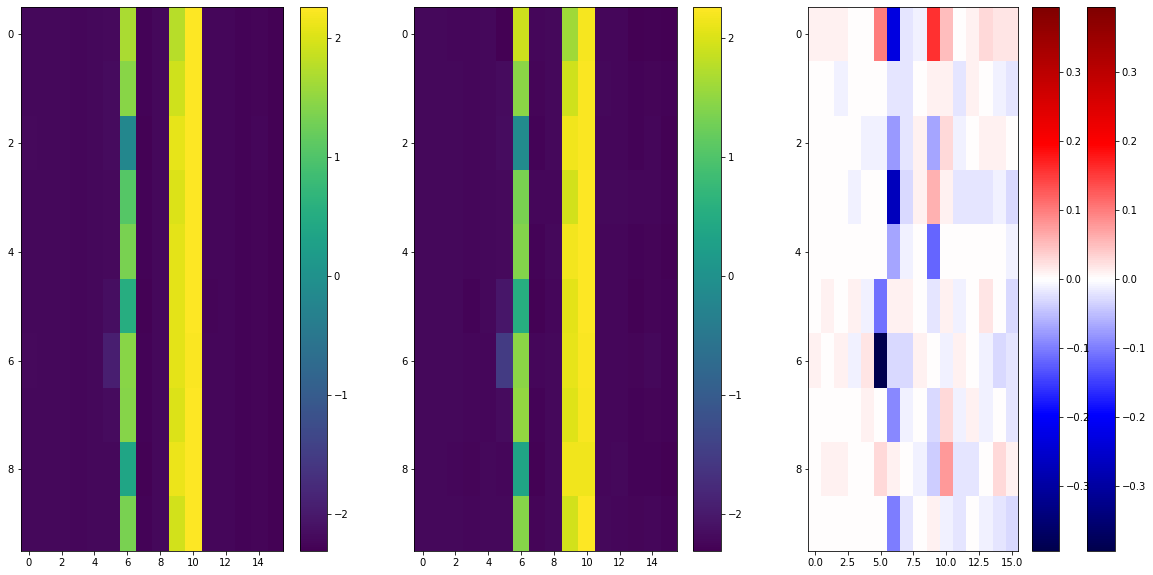

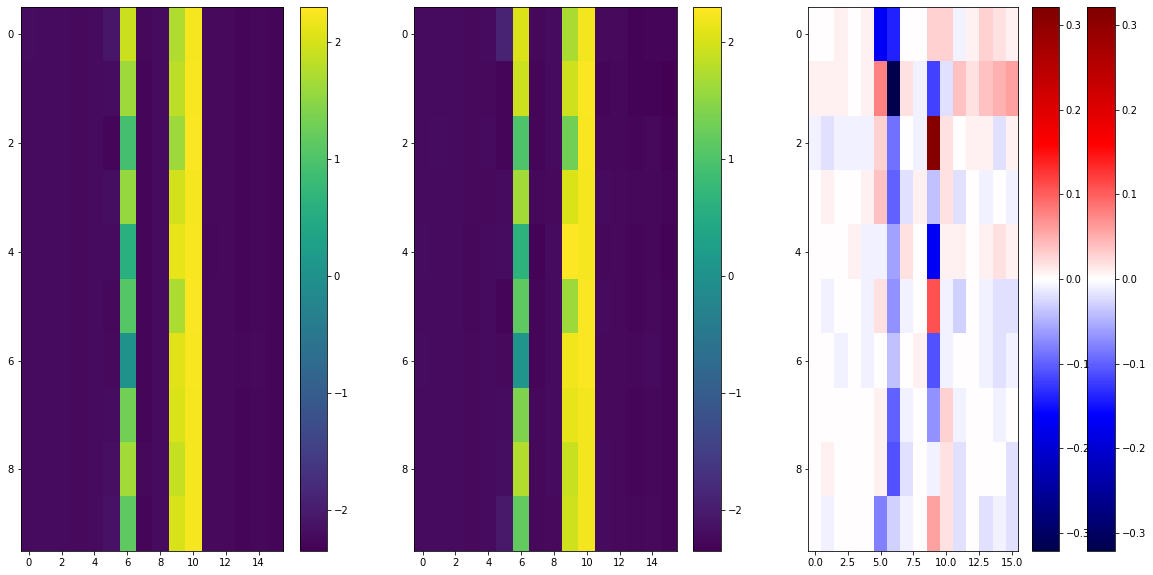

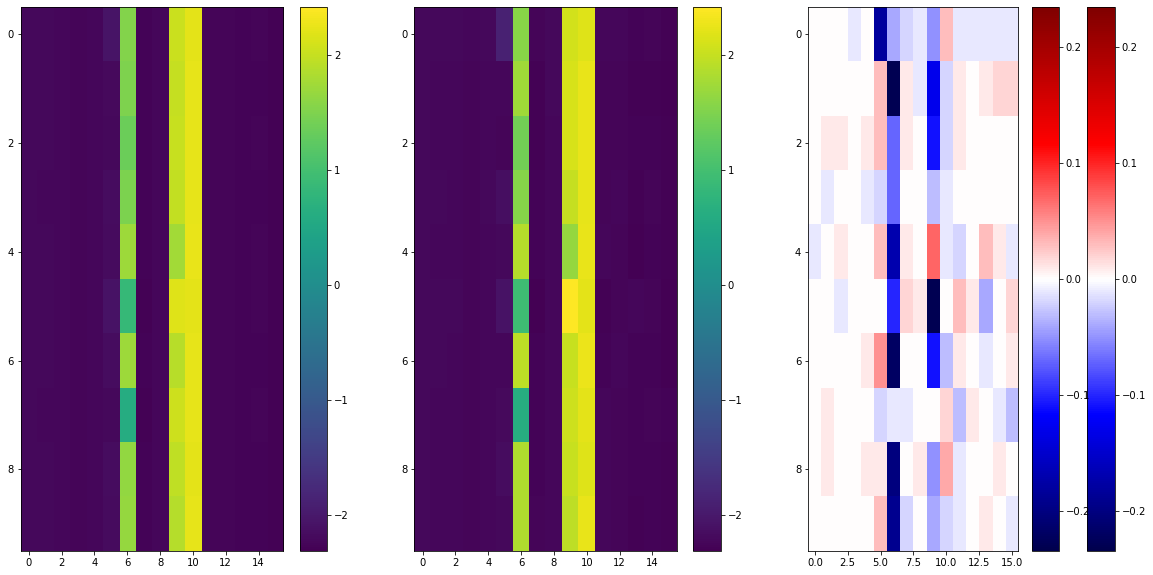

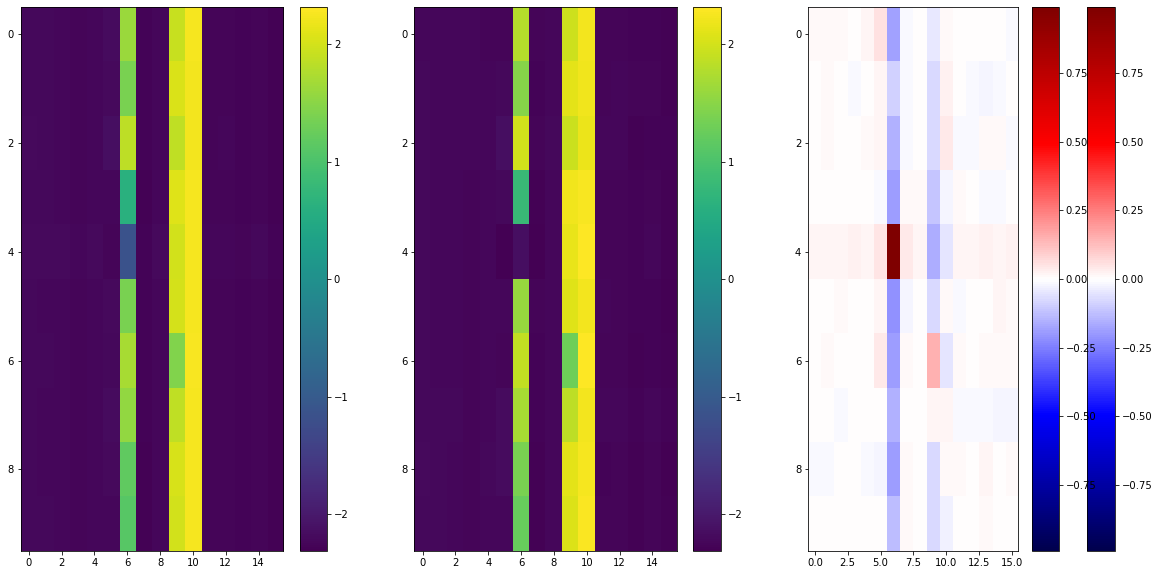

In [9]:
#check if g(.) and GP path match on test instances ====
FLAG_RELU = False
gpexmodule.renew_precomputed_XTX()
list_outputgpoutputg = gpexmodule.checkequal_GPout_ANNout_ontest(5)
for n in range(len(list_outputgpoutputg)):
    a = list_outputgpoutputg[n][0]
    b = list_outputgpoutputg[n][1]
    if(FLAG_RELU == True):
        a = np_relu(a); b = np_relu(b)
    
    min_ab = min(np.min(a), np.min(b))
    max_ab = max(np.max(a), np.max(b))
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(np.round(a, 2), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(np.round(b, 2), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(np.round(a-b, 2), cmap="seismic", vmin=-np.max(np.abs(a-b)),\
               vmax=np.max(np.abs(a-b)), aspect="auto"); plt.colorbar()
    plt.colorbar()
    plt.show()        

# Compute Correlation Coefficients

In [10]:
from sklearn.metrics import cohen_kappa_score
from scipy import stats

dict_idx_to_gpout, dict_idx_to_annout = gpexmodule.check_GPmatchANN_on_aDataloader(
    func_feed_dlinstances = model.func_feed_test_minibatch,
    func_get_lastidx_fedinstances = model.func_get_idxlastfed_testdl,
    list_allidx = [n for n in range(len(ds_test))]
)
list_gpout = []
list_annout = []
for n in range(len(ds_test)):
    list_gpout.append(dict_idx_to_gpout[n])
    list_annout.append(dict_idx_to_annout[n])
np_gpout = np.array(list_gpout)
np_annout = np.array(list_annout)

list_correlation = []
for c in range(np_gpout.shape[1]):
    list_correlation.append(
        stats.pearsonr(np_gpout[:, c], np_annout[:, c])[0]
    )
print("list correlation: \n")
for u in list_correlation:
    print(np.round(u, 3))

/home/user1/anaconda3/envs/envpy37/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


list correlation: ances out of 10000

0.031
0.036
0.324
0.36
-0.077
0.919
0.987
0.558
0.277
0.965
0.69
0.256
0.254
0.307
0.455
0.24


# Depict the Correlation Scatters

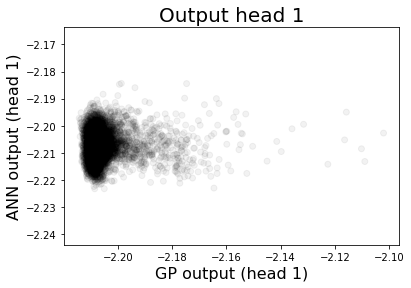

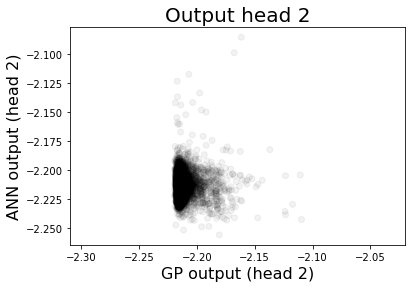

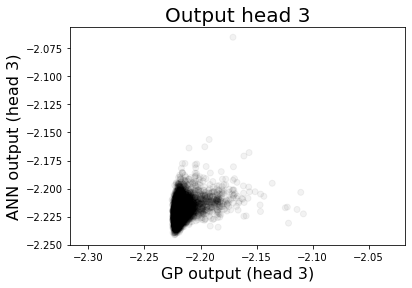

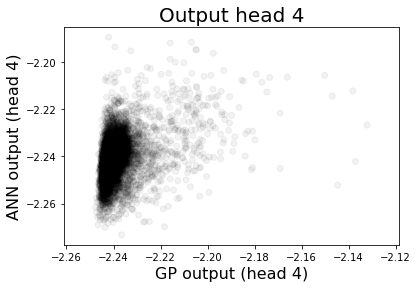

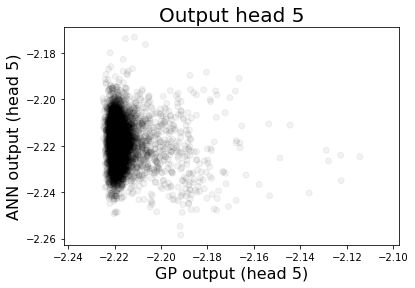

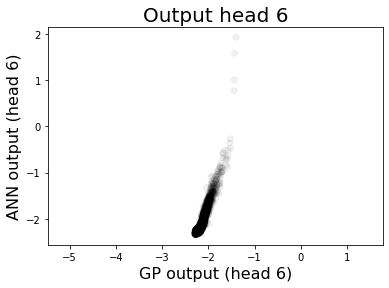

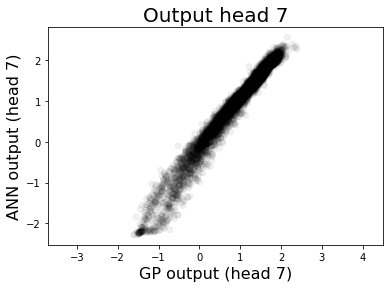

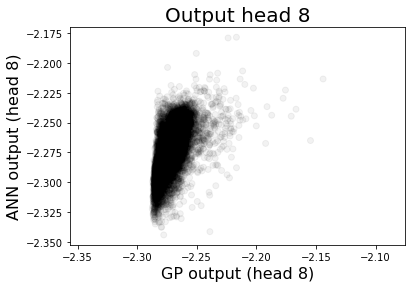

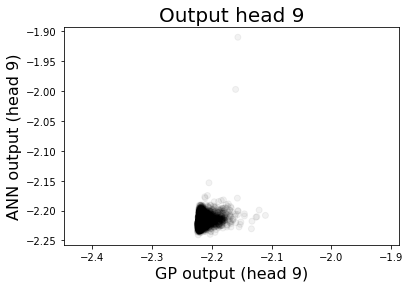

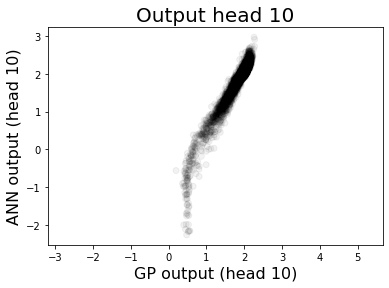

In [11]:
from scipy.special import softmax
np_gp = np_gpout #np_gpann[:,0:num_classes]
np_ann = np_annout #np_gpann[:,num_classes::]

list_disaggrement = (np.argmax(np_gp, 1) != np.argmax(np_ann, 1)).tolist()
list_c = [[0,0,0,0.05] if(True) else [0,0,0,0.05] for u in list_disaggrement]
count_plotted = 0
for c in range(num_classes):
    plt.figure()
    plt.scatter(np_gp[:,c], np_ann[:,c], c=np.array(list_c), marker='o', facecolors='none')
    plt.axis("equal")
    plt.xlabel("GP output (head {})".format(c+1), fontsize=16)
    plt.ylabel("ANN output (head {})".format(c+1), fontsize=16)
    plt.title("Output head {}".format(count_plotted+1), fontsize=20)
    count_plotted += 1
    plt.show()